In [1]:
#pytorch
import torch
from PIL import Image
from torchvision import transforms
import torchvision

#other lib
import sys
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# model_embedded_face (insightface)
from insightface.insight_face import iresnet100

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_emb = insight_face(path="insightface/ckpt_epoch_50.pth", device=device, train=True)
weight = torch.load("insightface/16_backbone.pth", map_location = device)
model_emb = iresnet100()
model_emb.load_state_dict(weight)
model_emb.to(device)
model_emb.eval()

face_preprocess = transforms.Compose([
                                    transforms.ToTensor(), # input PIL => (3,56,56), /255.0
                                    transforms.Resize((112, 112)),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                    ])

### 2. Test recognize 1 image (test INSIGHTFACE)

Folow step by step
- Đẩy toàn bộ ảnh trong database vô model InsightFace => database vectors
- Đẩy ảnh query (chỉ có face) vô model InsightFace => 1 vector query
- Compare vector query and database vectors (cosine simirity, abs, mse, ...) => result

In [27]:
# 1. Đẩy toàn bộ ảnh trong database vô model InsightFace => database vectors
def inference_database(root_path = "faces_database"):
    
    images_name = []
    images_emb = []
    
    for folder in os.listdir(root_path):
        if os.path.isdir(root_path + "/"+ folder):
            for name in os.listdir(root_path + "/" + folder):
                if name.endswith(("png", 'jpg', 'jpeg')):
                    path = f"{root_path}/{folder}/{name}"
                    
                    img_face = face_preprocess(Image.open(path).convert("RGB")).to(device)

                    with torch.no_grad():
                        emb_img_face = model_emb(img_face[None, :])[0].cpu().numpy()
                    
                    images_emb.append(emb_img_face)
                    images_name.append(name.split('.')[0])

    images_emb = np.array(images_emb)
    images_name = np.array(images_name)
    
    return images_name, images_emb/np.linalg.norm(images_emb, axis=1, keepdims=True)

name_images, emb_images = inference_database("faces_database")

In [28]:
%time

# 2. Đẩy ảnh query (chỉ có face) vô model InsightFace => 1 vector query
path_query = "face_quang.png"
img_query = face_preprocess(Image.open(path_query).convert("RGB")).to(device)
with torch.no_grad():
    emb_query = model_emb(img_query[None, :]).cpu().numpy()
    emb_query = emb_query/np.linalg.norm(emb_query)
    
    
# 3. Compare vector query and database vectors (cosine simirity, abs, mse, ...) => result

# Cosine simirity (cach 1)
# cosine_measure = emb_images @ emb_query.T
# print(name_images[cosine_measure.argmax()].split("_")[0])

# Mean square error (cach 2)
mse_measure = np.linalg.norm(emb_images - emb_query, axis=-1)
name_images[mse_measure.argmin()]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


'quang'

In [23]:
%%time

path_query = "quang.jpg"
orgimg = cv2.imread(path_query)  # BGR 
bboxs = [[390, 90, 615, 350]]
    

for i in range(len(bboxs)):
    x1, y1, x2, y2 = bboxs[i]
    roi = orgimg[y1:y2, x1:x2]
    roi = face_preprocess(Image.fromarray(roi)).to(device)
    
    with torch.no_grad():
        emb_query = model_emb(roi[None, :]).cpu().numpy()
        emb_query = emb_query/np.linalg.norm(emb_query)
    
    scores = (emb_query @ emb_images.T)[0]
    # scores = np.linalg.norm(norm_roi_emb - norm_images_emb)
    id_min = np.argmax(scores)
    score = scores[id_min]
    name = name_images[id_min]
    
    if score < 0.2:
        caption= "UN_KNOWN"
    else:
        caption = f"{name.upper()}"

    t_size = cv2.getTextSize(caption, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
    cv2.rectangle(orgimg, (x1, y1), (x2, y2), (0, 146, 230), 3)
    cv2.rectangle(
        orgimg, (x1, y1), (x1 + t_size[0], y1 + t_size[1]), (0, 146, 230), -1)
    cv2.putText(orgimg, caption, (x1, y1 + t_size[1]), cv2.FONT_HERSHEY_PLAIN, 2, [255, 255, 255], 2)

CPU times: user 101 ms, sys: 477 µs, total: 102 ms
Wall time: 38.1 ms


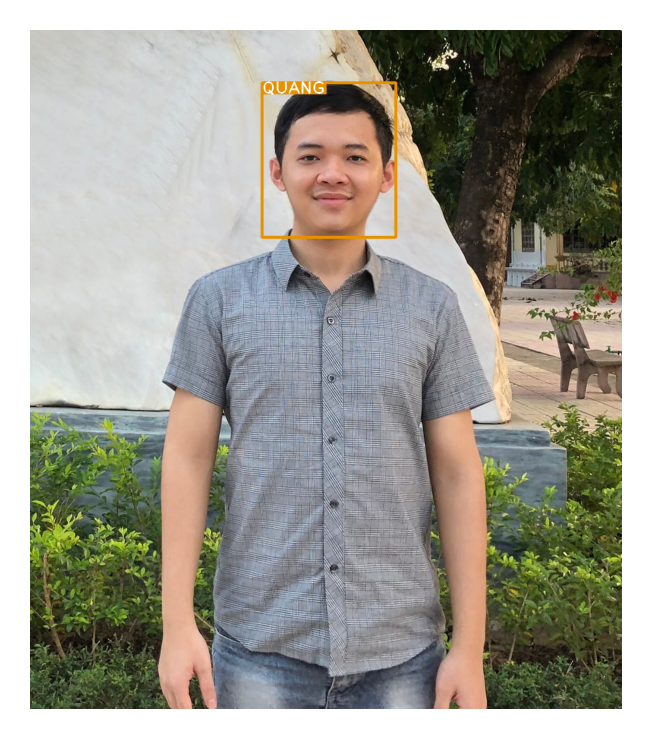

In [24]:
plt.figure(figsize=(5, 3), dpi=300)
plt.axis('off')
plt.imshow(orgimg[:,:,::-1]);

### 3. Test recognize 1 image (test INSIGHTFACE + YOLOV5)

Folow step by step
- Đẩy toàn bộ ảnh trong database vô model INSIGHTFACE => database vectors
- Cắt face ảnh query từ YOLOV5 sau đó đổ vô INSIGHTFACE => 1 vector query
- Compare vector query and database vectors (cosine simirity, abs, mse, ...) => result

In [ ]:
sys.path.insert(0, "yolov5_face")

from models.experimental import attempt_load
from utils.datasets import letterbox
from utils.general import check_img_size, non_max_suppression_face, scale_coords
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = attempt_load("yolov5_face/yolov5m-face.pt", map_location=device)

Fusing layers... 


In [8]:
size_convert = 640  # setup size de day qua model
conf_thres = 0.4
iou_thres = 0.5

In [9]:
def resize_image(img0, img_size):
    h0, w0 = orgimg.shape[:2]  # orig hw
    r = img_size / max(h0, w0)  # resize image to img_size
    if r != 1:  # always resize down, only resize up if training with augmentation
        interp = cv2.INTER_AREA if r < 1  else cv2.INTER_LINEAR
        img0 = cv2.resize(img0, (int(w0 * r), int(h0 * r)), interpolation=interp)

    imgsz = check_img_size(img_size, s=model.stride.max())  # check img_size
    img = letterbox(img0, new_shape=imgsz)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1).copy()  # BGR to RGB, to 3x416x416

    img = torch.from_numpy(img).to(device)
    img = img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    return img

In [37]:
%%time

path_query = "test_congphuong3.jpg"
orgimg = cv2.imread(path_query)  # BGR 
img = resize_image(orgimg.copy(), size_convert)

with torch.no_grad():
    pred = model(img[None, :])[0]
    
# Apply NMS
det = non_max_suppression_face(pred, conf_thres, iou_thres)[0]
bboxs = np.int32(scale_coords(img.shape[1:], det[:, :4], orgimg.shape).round().cpu().numpy())
    

for i in range(len(bboxs)):
    x1, y1, x2, y2 = bboxs[i]
    roi = orgimg[y1:y2, x1:x2]
    roi = face_preprocess(Image.fromarray(roi)).to(device)
    
    with torch.no_grad():
        emb_query = model_emb(roi[None, :]).cpu().numpy()
        emb_query = emb_query/np.linalg.norm(emb_query)
    
    scores = (emb_query @ emb_images.T)[0]
    # scores = np.linalg.norm(norm_roi_emb - norm_images_emb)
    id_min = np.argmax(scores)
    score = scores[id_min]
    name = name_images[id_min]
    
    if score < 0.2:
        caption= "UN_KNOWN"
    else:
        caption = f"{name.split('_')[0].upper()}:{score:.2f}"

    t_size = cv2.getTextSize(caption, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
    cv2.rectangle(orgimg, (x1, y1), (x2, y2), (0, 146, 230), 3)
    cv2.rectangle(
        orgimg, (x1, y1), (x1 + t_size[0], y1 + t_size[1]), (0, 146, 230), -1)
    cv2.putText(orgimg, caption, (x1, y1 + t_size[1]), cv2.FONT_HERSHEY_PLAIN, 2, [255, 255, 255], 2)

CPU times: user 209 ms, sys: 27.7 ms, total: 236 ms
Wall time: 173 ms


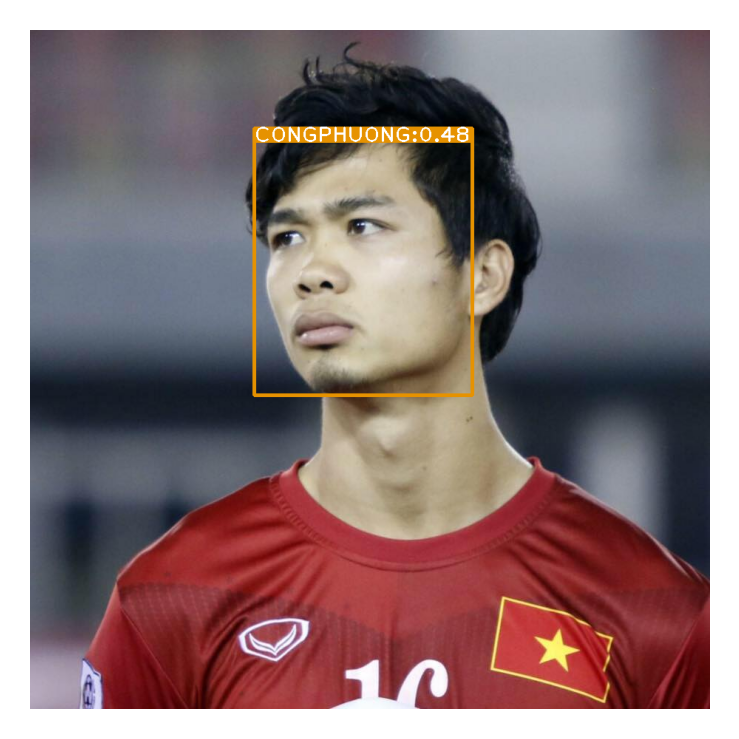

In [38]:
plt.figure(figsize=(5, 3), dpi=300)
plt.axis('off')
plt.imshow(orgimg[:,:,::-1]);

### 4. Test recognize video (test INSIGHTFACE + YOLOV5)

Folow step by step
- Đẩy toàn bộ ảnh trong database vô model INSIGHTFACE => database vectors
- Cắt face ảnh query từ YOLOV5 sau đó đổ vô INSIGHTFACE => 1 vector query
- Compare vector query and database vectors (cosine simirity, abs, mse, ...) => result

In [14]:
%%time

l = []
fps = 25
numsecond = 10

# Create read video instance
vidcap = cv2.VideoCapture('test_video.mp4')
success, orgimg = vidcap.read()

out = cv2.VideoWriter('output_test_video_0_15_yoloface.mp4',cv2.VideoWriter_fourcc(*'mp4v'), fps, (orgimg.shape[1], orgimg.shape[0]))
count = 0
while success:
    
    count += 1
    success, orgimg = vidcap.read()
    print(".", end="")
    
    if not success:
        break
        
    # if count >= numsecond * fps:
    #     break
        
    img = resize_image(orgimg.copy(), size_convert)

    with torch.no_grad():
        pred = model(img[None, :])[0]

    # Apply NMS
    det = non_max_suppression_face(pred, conf_thres, iou_thres)[0]
    bboxs = np.int32(scale_coords(img.shape[1:], det[:, :4], orgimg.shape).round().cpu().numpy())
    
    if len(bboxs) <= 0:
        continue
        
    faces = torch.zeros((len(bboxs), 3, 112, 112), dtype=torch.float32)
    for i in range(len(bboxs)):
        x1, y1, x2, y2 = bboxs[i]
        roi = orgimg[y1:y2, x1:x2]
        faces[i] = face_preprocess(Image.fromarray(roi))

    with torch.no_grad():
        emb_query = model_emb(faces.to(device)).cpu().numpy()
        emb_query = emb_query/np.linalg.norm(emb_query)

    # scores = np.linalg.norm(emb_query[:, None] - emb_images[None, :], axis=-1)
    # idxs = np.argmin(scores, axis=-1)
    # scores = np.sum(emb_query[:, None] * emb_images[None, :], axis=-1)
    scores = (emb_query @ emb_images.T)
    idxs = np.argmax(scores, axis=-1)


    for i in range(len(bboxs)):
        x1, y1, x2, y2 = bboxs[i]

        score = scores[i, idxs[i]] 
        name = name_images[idxs[i]]
        l.append(score)
        if score <= 0.15:
        # if score >= 1.3:
            caption= "UN_KNOWN"
        else:
            caption = f"{name.upper()}:{score:.2f}"

        t_size = cv2.getTextSize(caption, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
        cv2.rectangle(orgimg, (x1, y1), (x2, y2), (0, 146, 230), 3)
        cv2.rectangle(orgimg, (x1, y1), (x1 + t_size[0], y1 + t_size[1]), (0, 146, 230), -1)
        cv2.putText(orgimg, caption, (x1, y1 + t_size[1]), cv2.FONT_HERSHEY_PLAIN, 2, [255, 255, 255], 2)

    out.write(orgimg)
    
out.release()
vidcap.release()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

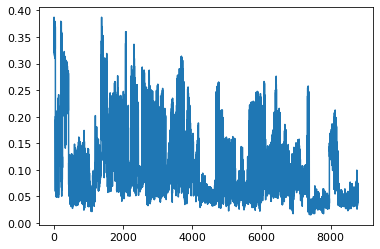

In [13]:
plt.plot(l)